In [1]:
#!pip -q install einops
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from set_data import load_real_weather, WeatherPairs, split_windows_train_val_test
from visualization import (plot_complete_data, 
                           plot_weatherpair_panel,
                           visualize_loss, plot_ctx_and_scenarios_panel, 
                           plot_ctx_and_scenarios_panel_ci)
from utils import *
from diffusion_model import DiffusionSchedule, TinyCondUNet1D
from diffusion_model_train import train_one_epoch, eval_epoch, EarlyStopping
from diffusion_model_generate import p_sample_loop
import error_metrics as em
np.set_printoptions(suppress=True)

VARS = 6
EPOCHS = 100
feature_names = ["T2M_MIN", "T2M_MAX", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN", "RH2M", "WS2M"]

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)



device: cpu


In [2]:

X, columns = load_real_weather("../../data/data_19950630_to_20250630.csv", 
                      start_date="1995-06-30", end_date="2024-06-30")
print("Real data shape:", X.shape)  # (days, number of features)


           DATE  T2M_MIN  T2M_MAX  PRECTOTCORR  ALLSKY_SFC_SW_DWN   RH2M  WS2M
8761 2019-06-25     1.69    11.30         0.04               9.15  75.54  0.75
4772 2008-07-23     4.79    12.16         0.85               9.42  84.33  0.98
8698 2019-04-23     7.56    25.33         0.03               8.12  66.90  1.09
4022 2006-07-04     7.39    20.77         0.01               8.64  77.84  1.42
3686 2005-08-02     6.00    13.78         2.16               4.04  89.74  0.92
Real data shape: (10594, 6)


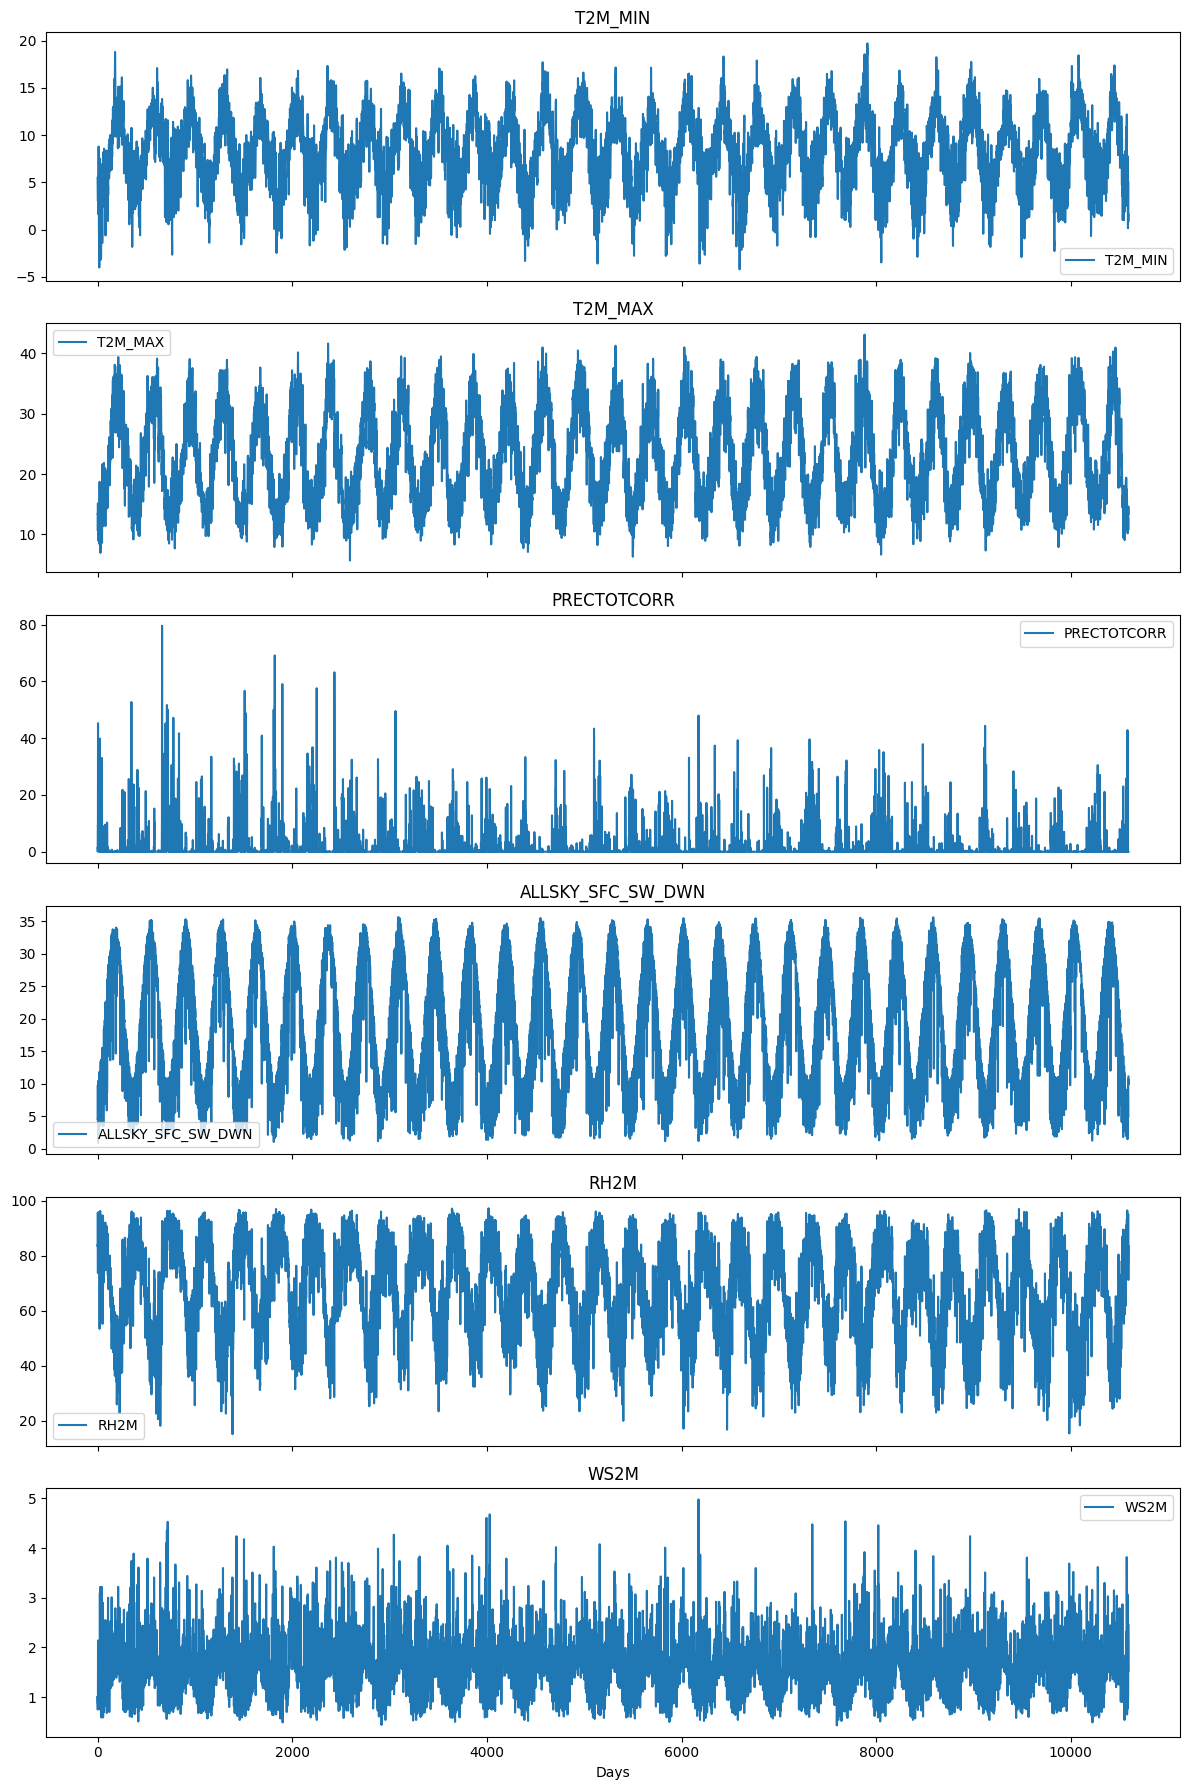

In [3]:
plot_complete_data(X, columns)

In [4]:
CTX = 90
HORIZON = 90
dataset = WeatherPairs(X, ctx=CTX, horizon=HORIZON, stride=1)
train_ds, val_ds, test_ds = split_windows_train_val_test(dataset, test_frac=0.1, val_frac=0.1, train_frac=0.8)



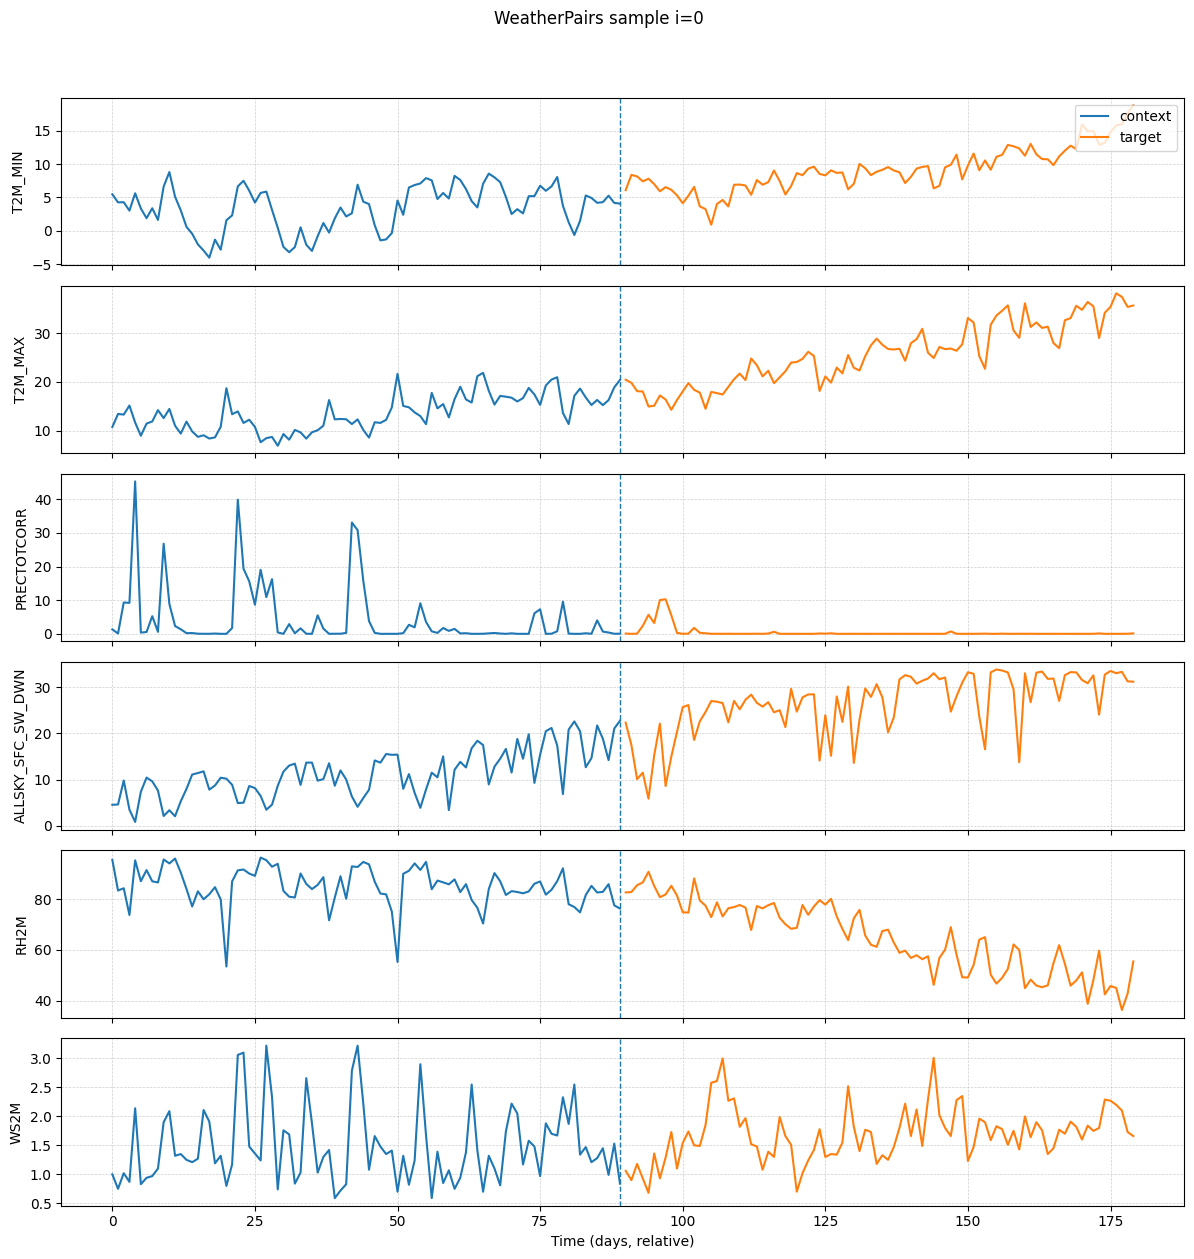

In [5]:
plot_weatherpair_panel(train_ds, i=0, feature_names=feature_names)

In [6]:
print("windows:", len(dataset))
print("train/val/test:", len(train_ds), len(val_ds), len(test_ds))
print("train date: ", train_ds.dataset.data[train_ds.indices[0]])
print("test date: ", test_ds.dataset.data[test_ds.indices[0]])
print("val date: ", val_ds.dataset.data[val_ds.indices[0]])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, drop_last=False)


windows: 10415
train/val/test: 7973 1041 1041
train date:  [ 5.48 10.78  1.32  4.57 95.47  1.  ]
test date:  [11.88 34.27  0.   27.09 42.08  1.78]
val date:  [ 7.66 21.55  0.   28.14 76.81  1.82]


In [8]:
mean, std = fit_standardizer(train_ds)
mean_t = torch.tensor(mean, device=device)
std_t = torch.tensor(std, device=device)
print("mean:", mean, "\nstd:", std)

mean: [ 8.264372  22.802605   1.5972173 18.573908  67.582726   1.6097491] 
std: [ 3.7077317   7.6234035   5.033372    9.887613   17.173027    0.57413685]


In [9]:
sched = DiffusionSchedule(T=300)

In [10]:
model = TinyCondUNet1D(in_vars=VARS, ctx_vars=VARS).to(device)


In [ ]:
#opt = torch.optim.RMSprop(model.parameters(), lr=2e-4)
opt = torch.optim.SGD(
    model.parameters(),
    lr=1e-2,
    momentum=0.9,
    weight_decay=1e-4,
    nesterov=True
)

train_hist, val_hist = [], []

early = EarlyStopping(patience=20, min_delta=1e-4, mode="min")

for e in range(1, EPOCHS + 1):
    tr = train_one_epoch(opt, model, sched, device, train_loader, mean_t, std_t)
    va = eval_epoch(model, device, val_loader, sched, mean_t, std_t)

    train_hist.append(float(tr))
    val_hist.append(float(va))

    print(f"epoch {e:02d} | train {tr:.4f} | val {va:.4f} | best {early.best:.4f} (bad {early.num_bad}/{early.patience})")

    if early.step(va, model, e):
        print(f"Early stopping at epoch {e:02d}. Best val={early.best:.4f} at epoch {early.best_epoch:02d}.")
        break

# restore best weights before final eval / saving
early.restore_best(model)

visualize_loss(len(train_hist), train_hist, val_hist)


epoch 01 | train 0.3858 | val 0.3052 | best inf (bad 0/20)
epoch 02 | train 0.3099 | val 0.2968 | best 0.3052 (bad 0/20)
epoch 03 | train 0.2876 | val 0.2879 | best 0.2968 (bad 0/20)
epoch 04 | train 0.2815 | val 0.2629 | best 0.2879 (bad 0/20)
epoch 05 | train 0.2760 | val 0.2676 | best 0.2629 (bad 0/20)
epoch 06 | train 0.2717 | val 0.2588 | best 0.2629 (bad 1/20)
epoch 07 | train 0.2685 | val 0.2446 | best 0.2588 (bad 0/20)
epoch 08 | train 0.2631 | val 0.2531 | best 0.2446 (bad 0/20)
epoch 09 | train 0.2605 | val 0.2430 | best 0.2446 (bad 1/20)
epoch 10 | train 0.2552 | val 0.2477 | best 0.2430 (bad 0/20)
epoch 11 | train 0.2548 | val 0.2524 | best 0.2430 (bad 1/20)
epoch 12 | train 0.2573 | val 0.2577 | best 0.2430 (bad 2/20)
epoch 13 | train 0.2524 | val 0.2516 | best 0.2430 (bad 3/20)
epoch 14 | train 0.2522 | val 0.2497 | best 0.2430 (bad 4/20)
epoch 15 | train 0.2465 | val 0.2592 | best 0.2430 (bad 5/20)
epoch 16 | train 0.2462 | val 0.2528 | best 0.2430 (bad 6/20)
epoch 17 | 

In [ ]:
df_dates = pd.read_csv('dates_loaded.csv', index_col=0)
index_date = df_dates[df_dates.DATE=='2024-01-01'].index.values[0]
print(index_date)

index_test = np.where(test_ds.indices== index_date)[0][0]

In [ ]:
ctx_raw, tgt_raw = test_ds[index_test]
ctx_raw = ctx_raw.unsqueeze(0)  # (1,60,6)
tgt_raw = tgt_raw.numpy()       # (60,6)

scens = p_sample_loop(ctx_raw, model, device, sched, HORIZON, VARS, 
                      mean_t, std_t, n_scenarios=50).numpy() 
days = np.arange(HORIZON)


In [ ]:
plot_ctx_and_scenarios_panel(
    ctx_raw,
    tgt_raw,
    scens,
    feature_names=feature_names,
    max_scen_to_plot=100
)


In [ ]:
plot_ctx_and_scenarios_panel_ci(ctx_raw, tgt_raw, scens)

In [ ]:
np.save("scenarios.npy", scens)

In [ ]:
Omega = np.load("scenarios.npy")

In [ ]:
df_summary = pd.DataFrame()

for i in range(test_ds.__len__()):
    ctx_raw, tgt_raw = test_ds[i]
    tgt_raw = tgt_raw.detach().cpu().numpy()
    ctx_raw = ctx_raw.unsqueeze(0)  # (1,CTX,VARS)
    scens = p_sample_loop(ctx_raw, model, device, sched, HORIZON, VARS,
                      mean_t, std_t, n_scenarios=100).detach().cpu().numpy()
    
    mse  = em.mse_ensemble_mean_batch(scens, tgt_raw).reshape(-1, 1)
    mae = em.mae_ensemble_mean_batch(scens, tgt_raw).reshape(-1, 1)
    crps_nd = em.crps_ensemble_snd(scens, tgt_raw, average=False).mean(axis=0)  # (60, 6)
    #print(f"Test sample {i+1}/{test_ds.__len__()} | MSE: {mse.mean():.4f} | MAE: {mae.mean():.4f} | CRPS_ND: {crps_nd.mean():.4f}")
    
    df_temp = pd.DataFrame({
        "mse": mse.flatten(),   
        "mae": mae.flatten(),
        "crps_nd": crps_nd.flatten()
    })
    df_summary = pd.concat([df_summary, df_temp], axis=0)


df_summary


In [ ]:
# pick a test sample
# i = 0
# ctx, tgt = test_ds[i]     # torch tensors

# move to numpy
# y = tgt.detach().cpu().numpy()   # shape: (H, D)
# inverse transform (broadcasting works)

In [ ]:
# y

In [ ]:
# Omega.shape

In [ ]:

# mse  = em.mse_ensemble_mean_batch(Omega, y)
# mae = em.mae_ensemble_mean_batch(Omega, y)

#print(f"MSE  : {mse:.4f}")
#print(f"MAPE : {mape:.2f}%")
#print(f"CRPS : {crps:.4f}")
# mse


In [ ]:
# mae

In [ ]:
# var_names = ["T2M_MIN", "T2M_MAX", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN", "RH2M", "WS2M"]
# crps_nd = em.crps_ensemble_snd(Omega, y, average=False)  # (60, 6)
# crps_per_var = crps_nd.mean(axis=0)  # (6,)
# for name, val in zip(var_names, crps_per_var):
#    print(name, val)


In [ ]:
#y.shape

In [ ]:

var_names = ["tmin", "tmax", "precip", "wind", "humidity", "solar"]

#X_mean = Omega.mean(axis=0)   # (60, 6)
X_mean = Omega[0]   # (60, 6)
df = pd.DataFrame(X_mean, columns=var_names)

sns.pairplot(df, corner=True, diag_kind="hist")
plt.show()

In [ ]:
# y.shape

In [ ]:
#X_mean = Omega.mean(axis=0)   # (60, 6)
i = 0
ctx, tgt = test_ds[i]     # torch tensors

# move to numpy
X_mean = tgt.detach().cpu().numpy()   # shape: (H, D)

# X_mean = y   # (60, 6)
df = pd.DataFrame(X_mean, columns=var_names)

sns.pairplot(df, corner=True, diag_kind="hist")
plt.show()

In [ ]:
# Omega.shape

In [ ]:
new_df = pd.DataFrame()
for i in range(Omega.shape[0]):
     new_df = pd.concat([new_df, pd.DataFrame(Omega[i], columns=var_names)], axis=0)

sns.pairplot(new_df, corner=True, diag_kind="hist")
plt.show()


In [ ]:
sns.pairplot(pd.DataFrame(X), corner=True, diag_kind="hist")
plt.show()

In [ ]:
new_df.corr()

In [ ]:
df.corr()